## <center><font color=navy>Python ile Algoritmik Ticaret</font></center>
### <center>Hisse Tarayıcısı</center>
#### <center>Serkan Polat</center>

Bir hisse senedi tarayıcı, yatırımcıların ve trader'ların belirli kriterlere göre hisse senetlerini filtrelemek için kullandığı bir araçtır. Bu, kullanıcıların teknik analiz göstergeleri, piyasa değeri, temettü verimi, fiyat/kazanç oranı (P/E), gelir büyümesi, endüstri ve diğer birçok faktör gibi metriklere göre piyasada bulunan hisse senetlerini aramasına ve analiz etmesine olanak tanır.

Hisse senedi tarayıcıları, yatırımcıların yatırım kriterlerine uygun hisse senetlerine odaklanmalarını sağlamak için seçenekleri daha yönetilebilir bir sayıya indirmelerine yardımcı olabilir. Bu araçlar, birçok finansal haber web sitesinde, aracı kurum platformlarında ve uzmanlaşmış yatırım araçlarında bulunabilir.

Örneğin, bir yatırımcı, teknoloji sektöründe temettü verimi yüksek ve belirli bir seviyenin altında P/E oranına sahip hisse senetlerini arıyorsa, bu kriterleri hisse senedi tarayıcısına girebilir ve bu koşulları karşılayan hisse senetlerinin bir listesini sunacaktır.

Hisse senedi tarayıcıları, platforma ve kullanıcının gereksinimlerine bağlı olarak basit veya son derece karmaşık olabilir. Hem acemi hem de deneyimli yatırımcılar için faydalı bir kaynaktır, stratejileri ve risk toleranslarıyla uyumlu potansiyel yatırım fırsatlarını belirlemelerine yardımcı olur.

Finviz ve TradingView gibi harika hisse senedi tarayıcı uygulamaları ve siteleri gibi birçok seçenek bulunmaktadır. Ancak, birçok site istediğiniz kadar özelleştirme sunmaz, eğer ödeme yapmazsanız.

Birkaç satır Python kodu ile kendi özelleştirilmiş basit hisse senedi tarayıcınızı oluşturabilirsiniz ve bu belge, size nasıl yapılacağını göstermek için burada bulunmaktadır.

Hisse senedi tarama süreci, belirli gereksinimlere uyan hisseleri elemek için çeşitli metrikler ve göstergeler kullanmayı içerir. İyi tasarlanmış bir hisse senedi tarama aracı, yatırımcılara zaman kazandırabilir ve yatırım stratejilerine uygun olan hisselere odaklanmalarına yardımcı olabilir.

## Python ile Hisse Filtresi Oluşturma

### Tüm S&P 500 şirket fiyatlarını tek bir Veri Çerçevesi'nde Birleştirme

In [1]:
%matplotlib inline

import yfinance as yf
import bs4 as bs
import numpy as np
import os
import missingno as msno
import requests
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
from pandas import ExcelWriter
import time
import yf.pdr_override()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pandas_ta as ta
from yahoo_fin import stock_info

In [2]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

soup=bs.BeautifulSoup(resp.text,"lxml")
table=soup.find("table",{"class":"wikitable sortable"})
tickers=[]

for row in table.findAll("tr")[1:]:
    ticker=row.findAll("td")[0].text
    tickers.append(ticker)
    
tickers = [s.replace('\n', '') for s in tickers]
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2023,6,30)

# S&P 500 endeksini takip eden sembol ^GSPC'dir, ancak bu endeks ticareti yapılamaz.
# SPY, S&P 500® Endeksini takip eden bir borsada işlem gören fon olan SPDR® S&P 500® ETF'nin borsa kodudur.

tickers=tickers+["^GSPC"];  
data = yf.download(tickers, start=start, end=end)['Adj Close']

# data = yf.download(tickers, period="5d", interval="1m")
print(data)

[*********************100%***********************]  504 of 504 completed

3 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- VLTO: Data doesn't exist for startDate = 1577854800, endDate = 1688097600
- BF.B: No data found for this date range, symbol may be delisted
                     A        AAL        AAPL        ABBV        ABNB  \
Date                                                                    
2020-01-02   83.779137  28.982893   73.249016   74.906540         NaN   
2020-01-03   82.433983  27.548195   72.536911   74.195526         NaN   
2020-01-06   82.677681  27.219410   73.114883   74.781059         NaN   
2020-01-07   82.931122  27.119778   72.771019   74.354462         NaN   
2020-01-08   83.749886  27.737495   73.941658   74.881432         NaN   
...                ...        ...         ...         ...         ...   
2023-06-23  118.952553  16.260000  186.428238  133.097458  124.730003   
2023-06-26  117.906670  16.440001  185.020157  132.14759

<Axes: >

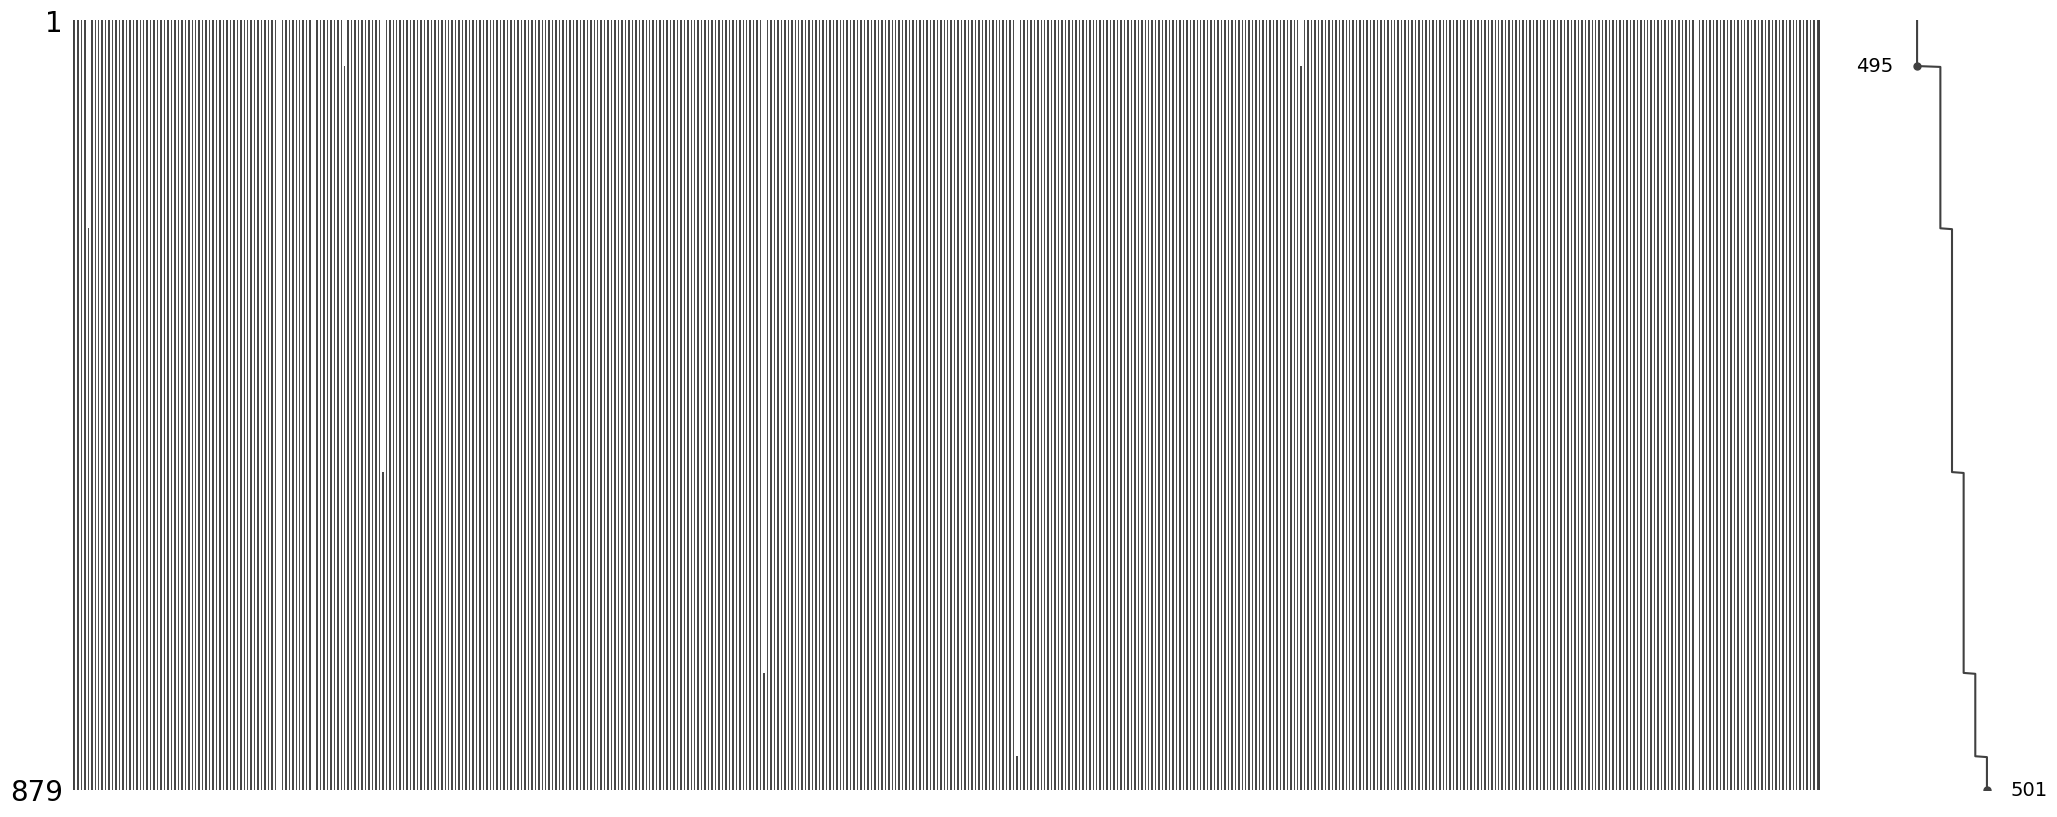

In [3]:
msno.matrix(data)

<Axes: >

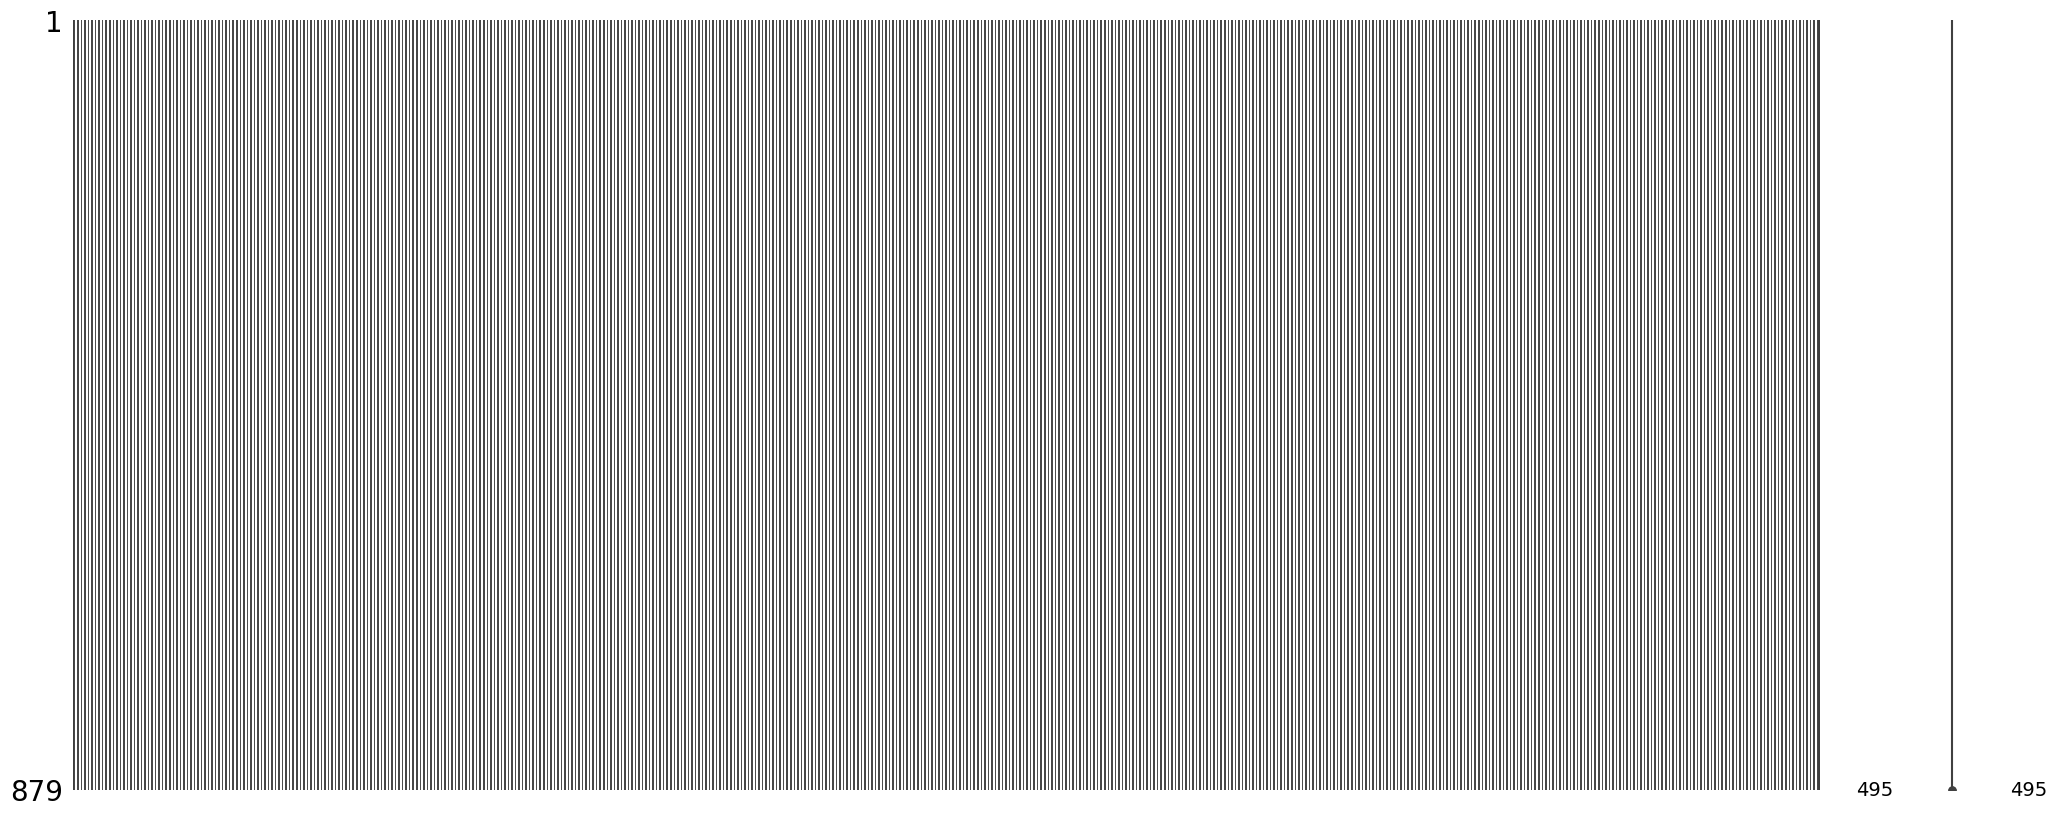

In [4]:
# Hesaplanmadan önce temizleyelim
cleaned_data=data.copy()

# Tüm zaman aralığı boyunca eksik değerlere sahip olan şirketleri (sütunları) kaldıralım
cleaned_data.dropna(axis="columns",how="all",inplace=True)

# Eksik değerlere sahip tüm şirketler için günleri (satırları) kaldıralım.
cleaned_data.dropna(axis="index",how="all",inplace=True)

# Son olarak, en az bir tane NaN (eksik değer) içeren sütunları kaldıralım.
cleaned_data.dropna(axis="columns",how="any",inplace=True)

msno.matrix(cleaned_data)

### Örnek 1: Mark Minervini'nin Trend Şablonu
Mark Minervini'nin Trend Şablonu'nu örnek olarak inceleyelim. Mark Minervini, ABD'li bir tüccar ve yazar olup "SEPA® yöntemi" veya Minervini Trend Şablonu olarak bilinen hisse senedi ticareti için belirli bir yöntem geliştirmiştir. Bu, temel ve teknik analizi birleştiren sistemli bir yaklaşımdır ve başlayan veya devam eden önemli bir yükseliş eğilimine sahip hisse senetlerini tanımlamak için kullanılır.

Mark Minervini'nin trend şablonunun aşama aşama açıklaması aşağıda verilmiştir:

#### 1. Fiyatın 150 ve 200 Günlük Hareketli Ortalamanın Üzerinde Olması
Hisse senedinin güncel fiyatı, 150 günlük ve 200 günlük basit hareketli ortalamasının üzerinde olmalıdır. Bu, hisse senedinin genel olarak yükseliş eğiliminde olduğundan emin olmak için kullanılır, çünkü fiyatın uzun vadeli bir hareketli ortalamasının üzerinde olması genellikle olumlu bir işaret olarak kabul edilir.

#### 2. 150 Günlük Hareketli Ortalamanın Yukarı Doğru Eğimli Olması veya 150 Günlük Hareketli Ortalamanın 200 Günlük Hareketli Ortalamayı Geçmesi
150 günlük hareketli ortalama kendisi yukarı doğru eğimli olmalıdır veya 150 günlük basit hareketli ortalama, 200 günlük basit hareketli ortalamayı geçmelidir. Bu, uzun vadeli eğilimin olumlu olduğunu ve hisse senedinin sürekli olarak doğru yönde ilerlediğini sağlar.

#### 3. Güncel Fiyatın 30 Günlük Hareketli Ortalamanın Üzerinde Olması
Hisse senedinin güncel fiyatı aynı zamanda 30 günlük hareketli ortalamasının üzerinde olmalıdır. Bu kısa vadeli hareketli ortalama, hisse senedinin anlık yükseliş eğiliminde olduğunu onaylamaya yardımcı olur.

#### 4. 30 Günlük Hareketli Ortalamanın 150 Günlük Hareketli Ortalamanın Üzerinde Olması
30 günlük hareketli ortalama, 150 günlük hareketli ortalamasının üzerinde olmalıdır. Bu hareketli ortalamaların hizalanması, hem kısa vadeli hem de uzun vadeli eğilimlerin olumlu olduğunu gösterir.

#### 5. Güncel Fiyatın 52 Haftalık Düşük Fiyatın En Az %30 Üzerinde Olması
Hisse senedinin güncel fiyatı, 52 haftalık düşük fiyatının en az %30 üzerinde olmalıdır. Bu, önemli bir yükseliş eğilimine zaten başlamış olan hisse senetlerini tanımaya yardımcı olur.

#### 6. Güncel Fiyatın 52 Haftalık Yüksek Fiyatın %25 İçinde Olması
Hisse senedinin güncel fiyatı, 52 haftalık yüksek fiyatının %25 içinde olmalıdır. Bu kriter, hisse senedinin son zirvelerine yakın işlem gördüğünden emin olmayı amaçlar, bu da bir güç göstergesidir.

#### 7. Göreceli Güç Derecesi (RSR)
Bir hissenin pazarın geri kalanına göre göreceli gücü göz önüne alınmalıdır ve bu değer 70'ten büyük olmalıdır (daha yüksek daha iyidir). RS derecesi, bir hissenin son bir yılda tüm diğer hisse senetleri ve genel pazar karşısındaki fiyat performansını ölçen bir metriktir. Minervini genellikle pazarı veya rakiplerini geride bırakan hisse senetlerini arar, çünkü bu, temel gücün göstergesi olabilir.

#### 8. Ortalama Günlük İşlem Hacmi
Minervini genellikle yeterli likiditeye sahip hisse senetlerini arar ve ortalama günlük işlem hacmini göz önüne alır. Daha yüksek işlem hacmi olan hisse senetleriyle işlem yapmak, işlem maliyetini azaltabilir ve pozisyonlara giriş ve çıkışı kolaylaştırabilir.

Bu kriterler, güçlü yükseliş eğilimine sahip hisse senetlerini tanımak için sistematik bir yaklaşımın bir parçası olarak kullanılabilir. Ancak, trend şablonunun güçlü bir araç olabileceğini unutmamak önemlidir. Ancak bu şablon, hisse senedinin temel analizi, piyasa koşulları ve risk yönetimi uygulamaları gibi diğer analizlerle birlikte kullanılmalıdır. Minervini'nin kitapları, özellikle "Trade Like a Stock Market Wizard," yöntemini daha ayrıntılı bir şekilde açıklar ve nasıl uygulanacağını gösterir.

In [7]:
tickers = si.tickers_sp500()
tickers = [item.replace(".", "-") for item in tickers] # Yahoo Finans, nokta yerine tire kullanır.
index_name = '^GSPC' # S&P 500
start_date = datetime.datetime.now() - datetime.timedelta(days=365)
end_date = datetime.date.today()
exportList = pd.DataFrame(columns=['Stock', "RS_Rating", "50 Day MA", "150 Day Ma", "200 Day MA", "52 Week Low", "52 week High"])
returns_multiples = []

In [9]:
index_df = pdr.get_data_yahoo(index_name, start_date, end_date)
index_df['Percent Change'] = index_df['Adj Close'].pct_change()
index_return = (index_df['Percent Change'] + 1).cumprod()[-1]

if not os.path.exists('ScanMarket'):
    os.makedirs('ScanMarket')

# S&P 500'ün göreceli olarak en iyi performans gösteren ilk %30 hisseyi bulun.
for ticker in tickers:
    # Her bir hisse senedi için tarih öncesindeki verileri CSV olarak indirin (işlemi hızlandırır).
    df = pdr.get_data_yahoo(ticker, start_date, end_date)
    df.to_csv(f'ScanMarket/{ticker}.csv')

    # Piyasaya göre getiri hesaplama (getiri çarpanı)
    df['Percent Change'] = df['Adj Close'].pct_change()
    stock_return = (df['Percent Change'] + 1).cumprod()[-1]
    
    returns_multiple = round((stock_return / index_return), 2)
    returns_multiples.extend([returns_multiple])
    
    print(f'Hisse: {ticker}; S&P 500 Endeksine Karşı Getiri Oranı: {returns_multiple}\n')
    time.sleep(1)

# Yalnızca üst 30%'luk veri çerçevesi oluşturma
rs_df = pd.DataFrame(list(zip(tickers, returns_multiples)), columns=['Ticker', 'Returns_multiple'])
rs_df['RS_Rating'] = rs_df.Returns_multiple.rank(pct=True) * 100
rs_df = rs_df[rs_df.RS_Rating >= rs_df.RS_Rating.quantile(.70)]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Hisse: A; S&P 500 Endeksine Karşı Getiri Oranı: 0.7

[*********************100%***********************]  1 of 1 completed
Hisse: AAL; S&P 500 Endeksine Karşı Getiri Oranı: 0.72

[*********************100%***********************]  1 of 1 completed
Hisse: AAPL; S&P 500 Endeksine Karşı Getiri Oranı: 1.04

[*********************100%***********************]  1 of 1 completed
Hisse: ABBV; S&P 500 Endeksine Karşı Getiri Oranı: 0.93

[*********************100%***********************]  1 of 1 completed
Hisse: ABNB; S&P 500 Endeksine Karşı Getiri Oranı: 1.0

[*********************100%***********************]  1 of 1 completed
Hisse: ABT; S&P 500 Endeksine Karşı Getiri Oranı: 0.9

[*********************100%***********************]  1 of 1 completed
Hisse: ACGL; S&P 500 Endeksine Karşı Getiri Oranı: 1.33

[*********************100%***********************]  1 of 

In [11]:
# Verilen liste içindeki en iyi %30 hissenin Minervini koşullarını kontrol etme
rs_stocks = rs_df['Ticker']
for stock in rs_stocks:    
    try:
        df = pd.read_csv(f'ScanMarket/{stock}.csv', index_col=0)
        sma = [50, 150, 200]
        for x in sma:
            df["SMA_"+str(x)] = round(df['Adj Close'].rolling(window=x).mean(), 2)
        
        # İstenen değerleri kaydetme
        currentClose = df["Adj Close"][-1]
        moving_average_50 = df["SMA_50"][-1]
        moving_average_150 = df["SMA_150"][-1]
        moving_average_200 = df["SMA_200"][-1]
        low_of_52week = round(min(df["Low"][-260:]), 2)
        high_of_52week = round(max(df["High"][-260:]), 2)
        RS_Rating = round(rs_df[rs_df['Ticker']==stock].RS_Rating.tolist()[0])
        
        try:
            moving_average_200_20 = df["SMA_200"][-20]
        except Exception:
            moving_average_200_20 = 0

        # Koşul 1: Güncel Fiyat, 150 Günlük Ortalama ve 200 Günlük Ortalama'dan büyük olmalıdır.
        condition_1 = currentClose > moving_average_150 > moving_average_200
        
        # Koşul 2: 150 Günlük Hareketli Ortalama ve 200 Günlük Hareketli Ortalama'dan Büyük Olma
        condition_2 = moving_average_150 > moving_average_200

        # Koşul 3: 200 Günlük Basit Hareketli Ortalama en az 1 aydır yükselişte
        condition_3 = moving_average_200 > moving_average_200_20
        
        # Koşul 4: 50 Günlük Hareketli Ortalama (SMA), hem 150 Günlük Hareketli Ortalama hem de 200 Günlük Hareketli Ortalama'dan büyük olmalıdır.
        condition_4 = moving_average_50 > moving_average_150 > moving_average_200
           
        # Koşul 5: Mevcut Fiyat, 50 Günlük Hareketli Ortalama (SMA) Değerinden Büyük Olmalıdır.
        condition_5 = currentClose > moving_average_50
           
        # Koşul 6: Güncel Fiyat, son 52 haftanın en düşük seviyesinin en az %30 üzerinde
        condition_6 = currentClose >= (1.3*low_of_52week)
           
        # Koşul 7: Mevcut Fiyat, son 52 haftanın en yüksek fiyatının %25'i içinde bulunuyor.
        condition_7 = currentClose >= (.75*high_of_52week)
        
        # Yukarıdaki tüm koşullar doğruysa, hisseyi "exportList"e ekleyin.
        if(condition_1 and condition_2 and condition_3 and condition_4 and condition_5 and condition_6 and condition_7):
            new_row = pd.DataFrame({'Hisse': [stock], 
                        "RS Değerlendirmesi": [RS_Rating], 
                        "50 Günlük Ortalama": [moving_average_50], 
                        "150 Günlük Ortalama": [moving_average_150], 
                        "200 Günlük Ortalama": [moving_average_200], 
                        "52 Haftalık Düşüş": [low_of_52week], 
                        "52 Haftalık Yüksek": [high_of_52week]})

            exportList = pd.concat([exportList, new_row], ignore_index=True)
            print(stock + " Minervini gereksinimlerini karşıladı.")
    except Exception as e:
        print (e)
        print(f"{stock} hakkında veri toplanamadı")


#writer = ExcelWriter("ScanMarket/ScreenOutput.xlsx")
#exportList.to_excel(writer, "Sheet1")
#writer.save()

ACGL Minervini gereksinimlerini karşıladı.
CBOE Minervini gereksinimlerini karşıladı.
MOH Minervini gereksinimlerini karşıladı.
NRG Minervini gereksinimlerini karşıladı.


In [12]:
def get_stock_price(code):
    # Başlangıç tarihini değiştirebilirsiniz
    data = yf.download(code, start="2023-01-01", progress=False, threads= False)
    return data

def add_EMA(price, day):
    return price.ewm(span=day).mean()

def add_STOCH(close, low, high, period, k, d=0): 
    STOCH_K = ((close - low.rolling(window=period).min()) / (high.rolling(window=period).max() - low.rolling(window=period).min())) * 100
    STOCH_K = STOCH_K.rolling(window=k).mean()
    if d == 0:
        return STOCH_K
    else:
        STOCH_D = STOCH_K.rolling(window=d).mean()
        return STOCH_D

def check_bounce_EMA(df):
    candle1 = df.iloc[-1]
    candle2 = df.iloc[-2]
    cond1 = candle1['EMA18'] > candle1['EMA50'] > candle1['EMA100']
    cond2 = candle1['STOCH_%K(5,3,3)'] <= 30 or candle1['STOCH_%D(5,3,3)'] <= 30
    cond3 = candle2['Low'] < candle2['EMA50'] and \
            candle2['Close'] > candle2['EMA50']
    return cond1 and cond2 and cond3

In [13]:
# Süzülen sonuçları depolamak için bir liste
screened_list = [] 
# Tam hisse senedi listesini alın.
stock_list = si.tickers_sp500()
stock_list = [item.replace(".", "-") for item in tickers] 
for stock_code in stock_list:
    try: 
        # Adım 1: Her bir hisse senedi için hisse fiyatını alın.
        price_chart_df = get_stock_price(stock_code)
        # Adım 2: Teknik Göstergeleri Ekleyin (Bu Durumda EMA)
        close = price_chart_df['Close']
        low = price_chart_df['Low']
        high = price_chart_df['High']
        price_chart_df['EMA18'] = add_EMA(close,18)
        price_chart_df['EMA50'] = add_EMA(close,50)
        price_chart_df['EMA100'] = add_EMA(close,100)
        price_chart_df['STOCH_%K(5,3,3)'] = add_STOCH(close, low, high, 5, 3)
        price_chart_df['STOCH_%D(5,3,3)'] = add_STOCH(close, low, high, 5, 3, 3)
        # Eğer tüm üç koşul da karşılanıyorsa, hisseyi filtrelenmiş listeye ekleyin.
        if check_bounce_EMA(price_chart_df):
            screened_list.append(stock_code)
            print(screened_list)
    except Exception as e:
        print(e)

['CTRA']
['CTRA', 'EG']
['CTRA', 'EG', 'MPC']
['CTRA', 'EG', 'MPC', 'NWS']
['CTRA', 'EG', 'MPC', 'NWS', 'OKE']
['CTRA', 'EG', 'MPC', 'NWS', 'OKE', 'TRGP']
['CTRA', 'EG', 'MPC', 'NWS', 'OKE', 'TRGP', 'WELL']
['CTRA', 'EG', 'MPC', 'NWS', 'OKE', 'TRGP', 'WELL', 'WMB']


### Örnek 3: S&P 500 için Hisse Senedi Filtreleme Stratejisi: Teknik ve Temel Analizin Birleşik Yaklaşımı

#### Giriş
Aşağıdaki strateji, S&P 500 endeksindeki potansiyel olarak değerli hisse senetlerini belirlemeyi amaçlayan bir yaklaşımı kullanır. Bu yaklaşım, teknik ve temel analizin birleşik bir yaklaşımını kullanarak, belirli kriterleri karşılayan hisse senetlerini elemek için sistemli bir yöntem kullanır. Bu kriterler, muhtemelen düşük değerli ve teknik açıdan olumlu pozisyonlar hedefler.

#### Kriterler
Filtreleme stratejisi, aşağıdaki üç koşula dayanmaktadır:

1. **Sıfırdan Büyük MACD (Hareketli Ortalama Yakınsama Ayrılma)**: MACD, bir güvenliğin fiyatının iki hareketli ortalaması arasındaki ilişkiyi vurgulayan bir momentum osilatörüdür. Sıfırdan büyük bir MACD, yükselen bir trendi ve yukarı yönlü bir eğilimi işaret edebilir, bu da hisse senedinin daha fazla büyüme potansiyeli taşıdığını gösterebilir.

2. **50'den Büyük RSI 14 (Göreceli Güç Endeksi)**: RSI, fiyat hareketlerinin hızını ve değişikliğini ölçen bir momentum göstergesidir ve 0 ile 100 arasında ölçeklendirilmiştir. 50'den büyük bir RSI değeri, genellikle güçlenen fiyat momentumunu yansıtır. Diğer faktörlerle birleştirildiğinde, bu, hisse senedinin ivme kazandığını ve daha fazla potansiyele sahip olabileceğini düşündürebilir.

3. **10'dan Düşük Fiyat/Kazanç Oranı (P/E Oranı)**: P/E oranı, güncel hisse fiyatını hisse başına kazançla karşılaştıran temel bir değerleme ölçüsüdür. 10'dan düşük bir P/E oranı, şirketin temellerinin sağlam olduğu sürece, değeri düşük hisse senedi bir işareti olabilir. Bu kriter, hisse senedinin kazançlarına göre göreceli olarak düşük fiyatlandırıldığından emin olmaya yardımcı olur.

#### Strateji Uygulaması
Yukarıdaki kriterleri uygulayarak, strateji S&P 500 hisse senetlerini eleyerek üç koşulu karşılayan hisse senetlerini bulur. Bu parametreleri karşılayan hisse senetleri, potansiyel büyüme (MACD ve RSI ile belirtilen) ve değer (düşük P/E oranı ile yansıtılan) kombinasyonu sunabilir.

#### Potansiyel Faydalar ve Riskler
Bu entegre yaklaşım, trendi takip eden yönleri değerlendirmelerle birleştirerek daha ayrıntılı bir bakış açısı sunabilir. Ancak, hiçbir filtreleme stratejisinin mükemmel olmadığını unutmamak önemlidir. Piyasa koşulları, beklenmedik haberler ve diğer öngörülemeyen faktörler hisse senedi performansını etkileyebilir.

Bu stratejiyi uygulayan yatırımcılar, şirketin finansal sağlığını, yönetim kalitesini ve endüstri görünümünü kapsayan daha fazla ön inceleme yapmayı düşünmelidir.

### Pandas Teknik Analiz (pandas-ta)
pandas-ta, finansal ve zaman serisi verilerini verimli bir şekilde işlemek ve analiz etmek için pandas kütüphanesiyle sorunsuz entegre olan 130'den fazla teknik gösterge sunan açık kaynaklı bir Python kütüphanesidir. Tecrübeli bir trader veya teknik analize yeni başlayan biri olun, pandas-ta, ticaret stratejilerini tasarlamak, test etmek ve uygulamak için basitleştirilmiş bir yaklaşım sunar.

In [14]:

# P/E Oranı Çıkarma Fonksiyonu
def get_pe_ratio(ticker):
    try:
        quote_table = stock_info.get_quote_table(ticker)
        pe_ratio = quote_table['PE Ratio (TTM)']
        return float(pe_ratio) if pe_ratio and pe_ratio != 'N/A' else None
    except:
        return None

# S&P 500 Hisse Senedi Sembolleri Al
sp500_tickers = stock_info.tickers_sp500()
start_date = '2023-01-01'


# Hisse Senetlerini Süzün
for ticker in sp500_tickers:
    try:
        print(f"{ticker} işleniyor")
        historical_data = stock_info.get_data(ticker, start_date=start_date)

        # Pandas ve TA Kullanarak MACD Hesaplama
        historical_data['MACD'] = ta.macd(historical_data['adjclose']).iloc[:, 0]

        # Pandas ve TA (Teknik Analiz) Kullanarak 14 Günlük RSI Hesaplayın
        historical_data['RSI14'] = ta.rsi(historical_data['adjclose'], length=14)

        # "RSI14" veya "MACD" içeren satırlardaki eksik değerleri (NaN) kaldırın.
        historical_data.dropna(subset=['RSI14', 'MACD'], inplace=True)

        # Fiyat Kazanç Oranı Al
        pe_ratio = get_pe_ratio(ticker)

        if pe_ratio is None:
            print(f"{ticker} için uygun P/E oranı mevcut olmadığından atlanıyor.")
            continue

        # Koşullara Göre Hisseleri Filtrele
        filtered_data = historical_data[
            (historical_data['RSI14'] > 50) &
            (historical_data['MACD'] > 0) &
            (pe_ratio < 10)
        ]

        if not filtered_data.empty:
            print(f"{ticker} hissesi kriterleri karşılıyor.")
            print(f"Son MACD değeri: {filtered_data['MACD'].iloc[-1]}") # Bu hisse senedi için son MACD değerini yazdır
            print(f"Son RSI değeri: {filtered_data['RSI14'].iloc[-1]}") # Bu sembol için son RSI değerini yazdır
            print(f"P/E oranı: {pe_ratio}")  # Bu sembol için P/E oranını yazdır
    except Exception as e:
        print(f"{ticker} için bir hata oluştu: {str(e)}")
        continue

print("Ekranda görüntüleme tamamlandı.")

A işleniyor
AAL işleniyor
AAL hissesi kriterleri karşılıyor.
Son MACD değeri: 0.7323452263572534
Son RSI değeri: 68.50877420738712
P/E oranı: 4.57
AAPL işleniyor
ABBV işleniyor
ABNB işleniyor
ABT işleniyor
ACGL işleniyor
ACN işleniyor
ADBE işleniyor
ADI işleniyor
ADM işleniyor
ADM hissesi kriterleri karşılıyor.
Son MACD değeri: 0.8757464649916358
Son RSI değeri: 50.85020503700323
P/E oranı: 9.74
ADP işleniyor
ADSK işleniyor
AEE işleniyor
AEP işleniyor
AES işleniyor
AFL işleniyor
AIG işleniyor
AIG hissesi kriterleri karşılıyor.
Son MACD değeri: 0.05361232189939358
Son RSI değeri: 50.78290765554567
P/E oranı: 9.07
AIZ işleniyor
AJG işleniyor
AKAM işleniyor
ALB işleniyor
ALB hissesi kriterleri karşılıyor.
Son MACD değeri: 5.564528783473804
Son RSI değeri: 53.96582326254514
P/E oranı: 4.04
ALGN işleniyor
ALK işleniyor
ALL işleniyor
ALLE işleniyor
AMAT işleniyor
AMCR işleniyor
AMD işleniyor
AME işleniyor
AMGN işleniyor
AMP işleniyor
AMT işleniyor
AMZN işleniyor
ANET işleniyor
ANSS işleniyor